# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [1]:
import sys
import math
import warnings
import itertools
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

sys.path.append('../')
from Data.load_data import get_input_data
from utils import search_optimal_params

# viz configs
from matplotlib import rcParams
import seaborn as sns
rcParams["figure.figsize"] = 25, 8
rcParams["timezone"] = "UTC"
sns.set_style("whitegrid")

## Model Choice

Auto regressive Integrated Moving Average(ARIMA) models are classical statistical models. These models are used to assess the dataset, initial modeling and ultimately comparison against advanced and more SOTA models.

Considering **Seasonal ARIMA**


## Feature Selection

[Indicate which features from the dataset you will be using for the baseline model, and justify your selection.]


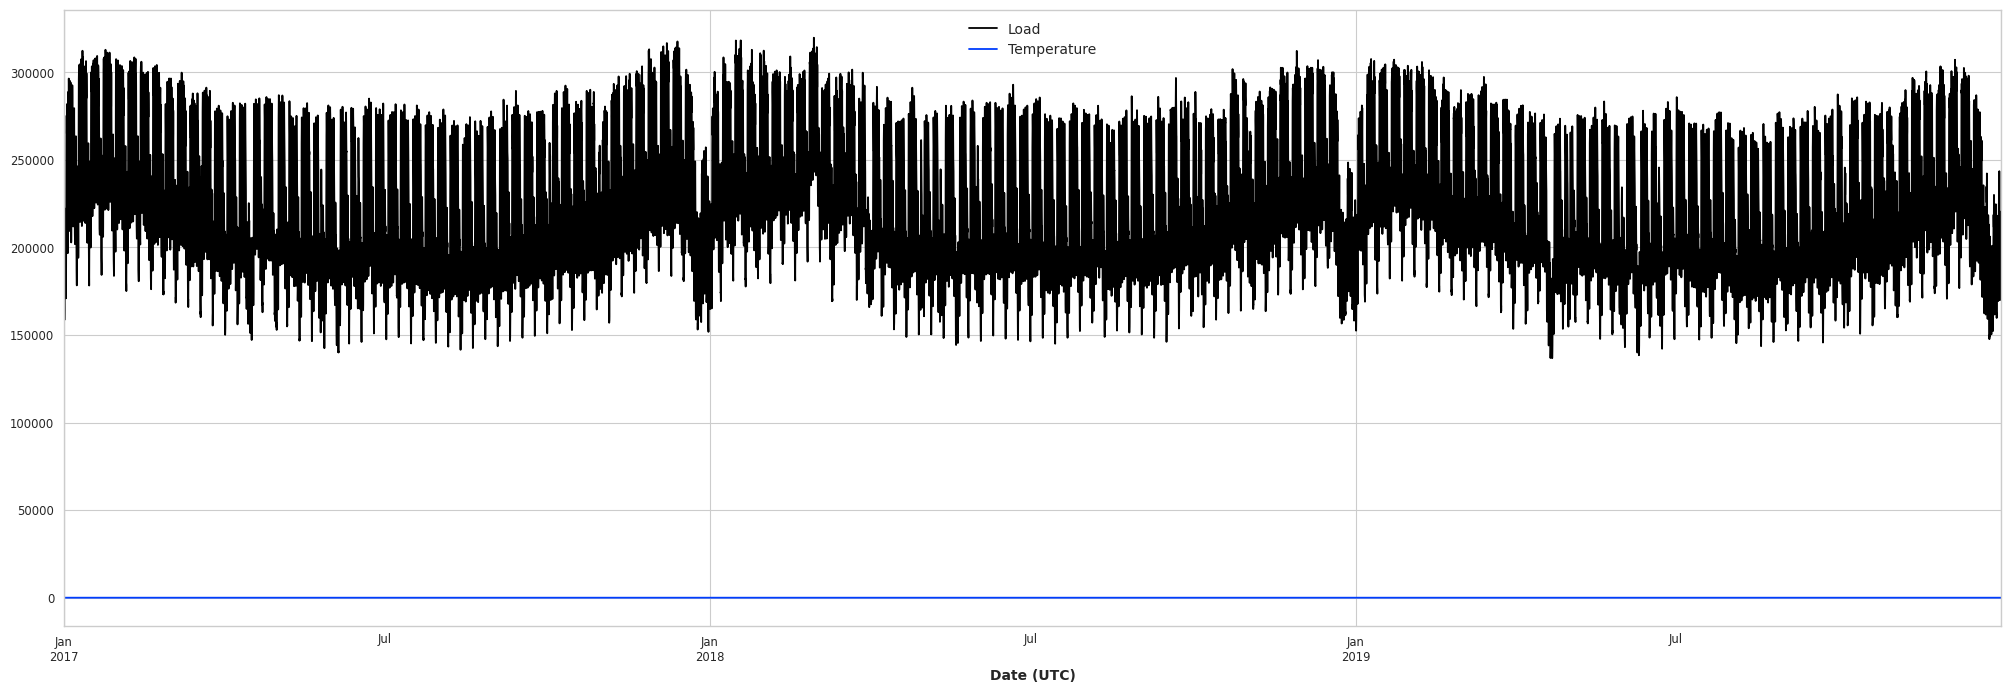

In [2]:
data_frame = get_input_data()
data_frame.plot()
plt.show()

In [3]:
df = data_frame.copy()

df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_of_week
df['day'] = df.index.day
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear
df['is_weekend'] = df.index.weekday // 5

In [ ]:
decomposition = sm.tsa.seasonal_decompose(data_frame["Load"], model='additive', period=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

In [ ]:
# check stationarity
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test : if p-value < 0.05, data is stationary
result = adfuller(data_frame)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))


# KPSS Test : if p-value < 0.05, data is not stationary
result = kpss(data_frame)
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t{}: {}'.format(key, value))

In [ ]:
# check autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_frame)
plt.legend()
plt.show()

plot_pacf(data_frame)
plt.legend()

plt.show()

In [4]:
# train test split
data_frame = df
split_point = int(len(data_frame) * 0.8)
train_set, test_set = data_frame[:split_point], data_frame[split_point:]
print("train set: {}, test set: {}".format(len(train_set), len(test_set)))

train set: 21024, test set: 5256


## Implementation

**Grid Search | Parameter Optimization**

In [5]:
warnings.filterwarnings("ignore")

p_values = range(0, 2)  # Autoregressive order
d_values = range(0, 2)  # Differencing order
q_values = range(0, 2)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [24]         # Seasonal period : daily

param_combinations = list(itertools.product(
    p_values, d_values,  q_values,
    P_values, D_values,  Q_values,
    m_values
))

best_params, best_aic = search_optimal_params(param_combinations, train_set)

order: (0, 0, 0), seasonal_order: (0, 0, 0, 24), AIC: 689137.6946293598
order: (0, 0, 0), seasonal_order: (0, 0, 1, 24), AIC: 489532.71007386857
order: (0, 0, 0), seasonal_order: (1, 0, 0, 24), AIC: 470699.7997722463
order: (0, 0, 0), seasonal_order: (1, 0, 1, 24), AIC: 467408.0558686998
order: (0, 0, 1), seasonal_order: (0, 0, 0, 24), AIC: 484808.020071788
order: (0, 0, 1), seasonal_order: (0, 0, 1, 24), AIC: 471833.2180551838
order: (0, 0, 1), seasonal_order: (1, 0, 0, 24), AIC: 259161.1639544681
order: (0, 0, 1), seasonal_order: (1, 0, 1, 24), AIC: 477006.83241996594
order: (0, 1, 0), seasonal_order: (0, 0, 0, 24), AIC: 636265.4765228413
order: (0, 1, 0), seasonal_order: (0, 0, 1, 24), AIC: 431125.47852231783
order: (0, 1, 0), seasonal_order: (1, 0, 0, 24), AIC: 418100.2138081781
order: (0, 1, 0), seasonal_order: (1, 0, 1, 24), AIC: 413561.0241948633
order: (0, 1, 1), seasonal_order: (0, 0, 0, 24), AIC: 431595.0774514959
order: (0, 1, 1), seasonal_order: (0, 0, 1, 24), AIC: 422458.6

- order: (1, 0, 0), seasonal_order: (1, 0, 1, 24), AIC: 20.0
- order: (1, 0, 1), seasonal_order: (1, 0, 1, 24), AIC: 22.0

In [10]:
# best_params = [1, 0, 0, 1, 0, 1, 24]
best_params = [1, 0, 1, 1, 0, 1, 24]

In [11]:
import statsmodels
model = statsmodels.tsa.statespace.sarimax.SARIMAX(
    endog=train_set["Load"],
    exog=train_set[['hour', 'day_of_week', 'day', 'month', 'day_of_year', 'is_weekend']],
    order=best_params[:3],
    seasonal_order=best_params[3:]
)
results = model.fit(disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Load   No. Observations:                21024
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood                   0.000
Date:                            Sun, 28 Jan 2024   AIC                             22.000
Time:                                    17:32:33   BIC                            109.488
Sample:                                12-31-2016   HQIC                            50.554
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
hour          998.6093         -0       -inf      0.000     998.609     998.609
day_of_week   678.7682         -0       -inf      0.000     678.768     678.768
day          7661.0141         -0       -inf      0.000    7661.014    7661.014
month        2.315e+05         -0       -inf      0.000    2.31e+05    2.31e+05
day_of_year -7437.8950         -0        inf      0.000   -7437.895   -7437.895
is_weekend  -4.397e+04         -0        inf      0.000    -4.4e+04    -4.4e+04
ar.L1           0.9440         -0       -inf      0.000       0.944       0.944
ma.L1           0.3963         -0       -inf      0.000       0.396       0.396
ar.S.L24        1.0000         -0       -inf      0.000       1.000       1.000
ma.S.L24       -0.9945         -0        inf      0.000      -0.994      -0.994
sigma2       8.018e+07         -0       -inf      0.000    8.02e+07    8.02e+07
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [12]:
prediction = results.get_prediction(
    start=test_set.index[0], end=test_set.index[-1],
    exog=test_set[['hour', 'day_of_week', 'day', 'month', 'day_of_year', 'is_weekend']]
).predicted_mean

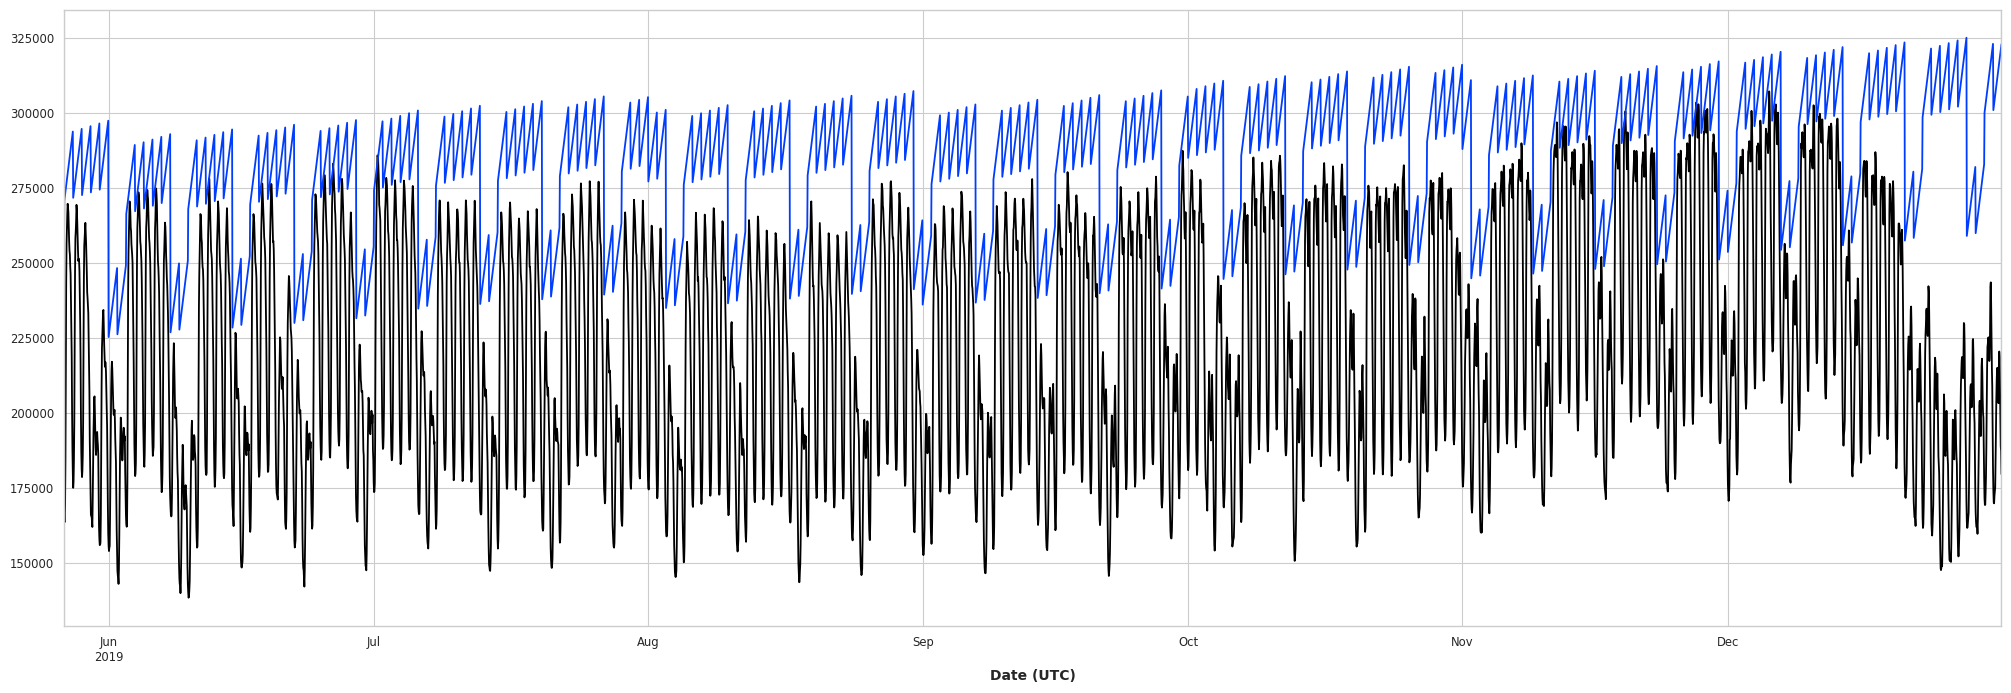

In [13]:
test_set["Load"].plot()
prediction.plot()
plt.savefig("baseline_model.png")
plt.show()

## Evaluation

In [14]:
sys.path.append('../3_Models')
from helper_functions import create_error_metrics

error_metrics = create_error_metrics(test_set["Load"], prediction)
error_metrics

,MAE,MSE,RMSE,MAPE %,R2 %
0,60991.09,4.839568e+09,69567.0,30.6,-219.64


|models|MAE|MSE|MAPE %| R2 |
|--|--|--|--|--|
|sarima|60991.09|4.839568e+09|69567.0|30.6|-219|

___